In [1]:
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

from IPython.display import HTML
import matplotlib.cm as cm
import numpy as np
from typing import Union
import math

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from lib.model_reduction_variant import Extractor
from lib.anomaly_detection import LOCIMatrix, LOCIMatrixNew
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
pd.options.display.notebook_repr_html = False 
plt.rcParams['figure.dpi'] = 75 
sns.set_theme(style='darkgrid') 

In [18]:
from lib.model_utils import ModelUtil
model = ModelUtil(data_name = 'german_credit', model_name = 'RF')
paths = model.paths
mat = model.get_cover_matrix(model.X, fuzzy = True, byclass = False)

Test
Accuracy Score is 0.828
Precision Score is 0.8663101604278075
F1 Score is 0.88283378746594
Train
Accuracy Score is 0.8932692307692308


In [4]:

import copy
feature_pos = copy.deepcopy(model.feature_pos)

is_feature_categorical = {}
feature_val_idxs = {}
for i in model.feature_pos:
    if i == -1:
        continue
    feature, index = model.feature_pos[i]
    is_feature_categorical[feature] = index > 0

for i in model.feature_pos:
    if i == -1:
        continue
    feature, index = model.feature_pos[i]
    if is_feature_categorical[feature]:
        if feature not in feature_val_idxs:
            feature_val_idxs[feature] = []
        if i >= 0:
            feature_val_idxs[feature].append(i)

is_categorical = []
feature_range = []
for i in model.feature_pos:
    if i == -1:
        continue
    feature, index = model.feature_pos[i]
    is_categorical.append(is_feature_categorical[feature])
    feature_range.append(model.feature_range[feature])

n_features = len(is_categorical)
to_category_idx = [3]
for i in to_category_idx:
    name = model.feature_pos[i][0]
    is_categorical[i] = True
    feature_len =  model.feature_range[name][1] - model.feature_range[name][0]
    idx = [i for i in range(n_features, n_features + feature_len)]
    for it, j in enumerate(idx):
        feature_pos[j] = (name, it)
    feature_val_idxs[name] = idx
    n_features += feature_len

X = []
y = []
for p in paths:
    m = p['range']
    row = np.zeros(n_features)
    for i in m:
        if is_categorical[i]:
            if i in to_category_idx:
                left = int(max(feature_range[i][0], math.floor(m[i][0])))
                right = int(min(feature_range[i][1], math.ceil(m[i][1])))
                if feature_range[i][0] > 0:
                    left -= feature_range[i][0]
                    right -= feature_range[i][0]
                for j in range(left, right):
                    if j < len(feature_val_idxs[feature]):
                        row[feature_val_idxs[feature][j]] = 1
            else:
                if m[i][1] > 1:
                    row[i] = 1
                else:
                    if row[i] == 0:
                        feature, _ = model.feature_pos[i]
                        row[feature_val_idxs[feature]] = 1
                    row[i] = 0
        else:
            left = int(max(feature_range[i][0], m[i][0]))
            right = int(min(feature_range[i][1] - 1, m[i][1]))
            left = model.get_sum(i, 1, left) / len(model.X)
            right = model.get_sum(i, 1, right) / len(model.X)
            row[i] = (left + right) / 2 - 0.5
    for feature in feature_val_idxs:
        idx = feature_val_idxs[feature]
        tot = row[idx].sum()
        if tot > 0:
            row[idx] /= tot

    X.append(row)
    y.append(p['output'])
X = np.array(X).astype('float')
lr_mat = X
y = np.array(y)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X[:], y[:])
y_pred = lr.predict(X)
from sklearn.metrics import accuracy_score, precision_score, f1_score
print('Accuracy Score is', accuracy_score(y, y_pred))
prob1 = lr.predict_proba(X)[:, 0] * (y != y_pred)
outlier1 = prob1.argsort()[-50:][::-1].tolist()
prob2 = lr.predict_proba(X)[:, 1] * (y != y_pred)
outlier2 = prob2.argsort()[-50:][::-1].tolist()

Accuracy Score is 0.8186523134251112


In [5]:
predict_proba = lr.predict_proba(X)
score1 = np.array([predict_proba[i, 1 - y[i]] for i in range(predict_proba.shape[0])])

In [95]:
score1[:10]

array([0.02332788, 0.95615952, 0.06012734, 0.19277185, 0.00670663,
       0.09110545, 0.0740302 , 0.47783695, 0.22089863, 0.46865872])

In [137]:
res.sorted_dist[1216, 100]

5.121352004134609

In [92]:
score1 = lr.predict_proba(X).max(axis = 1) * (y != y_pred)

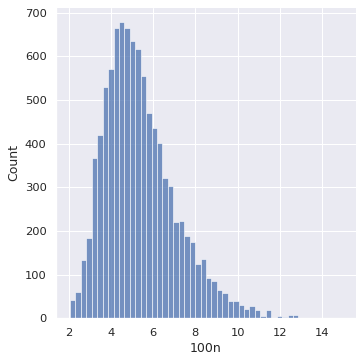

In [132]:
consistency_data = pd.DataFrame({ '100n': res.sorted_dist[:, 100] })
sns.displot(data=consistency_data, x="100n", bins=50, log_scale=(False, False))
plt.show()

In [31]:
predict_proba = lr.predict_proba(X)
score1 = np.array([predict_proba[i, 1 - y[i]] for i in range(predict_proba.shape[0])])
score2 = res.check_consistency(res.sorted_dist[:, 100].mean(), [p['output'] for p in paths])
score2 = np.array(score2)
score_max = score2.max()
score_min = score2.min()
score2 = (score_max - score2) / (score_max - score_min)

In [32]:
score3 = np.array([p['confidence'] for p in paths])
score_max = score3.max()
score_min = score3.min()
score3 = (score_max - score3) / (score_max - score_min)

In [74]:
for s in [score1, score2, score3]:
    positives = [i for i in s.argsort()[-50:][::-1] if paths[i]['output'] == 1]
    print(len(positives))

3
50
43


In [68]:
score = (score1 + score2 + score3) / 3
outlier = score.argsort()[-50:][::-1]

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

data = pd.DataFrame(lr_mat)
X = data[[i for i in range(lr_mat.shape[1])]]
X[lr_mat.shape[1]] = 1

for i in range(lr_mat.shape[1]):
    name, pos = feature_pos[i]
    if name in model.current_encoding and name in feature_val_idxs:
        val = ' "' + model.current_encoding[name][pos] + '"'
    else:
        val = ''
    c = variance_inflation_factor(X.values, i)
    print('%s, vif: %.4f, coef: %.4f' % (name + val, c, lr.coef_[0][i]))

status, vif: 1.0860, coef: 9.8232
duration, vif: 1.0295, coef: -4.3244
amount, vif: 1.0239, coef: -0.7190
savings "unknown/no savings account", vif: nan, coef: 0.0000
employment_duration, vif: 1.0095, coef: 1.7679
installment_rate, vif: 1.0135, coef: -3.3585


/home/lizhen/miniconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


personal_status_sex, vif: 1.0652, coef: 0.8254
present_residence, vif: 1.0041, coef: -0.2455
age, vif: 1.0114, coef: 1.9279
credit_history "delay in paying off in the past", vif: 2.7609, coef: -1.6712
credit_history "critical account/other credits elsewhere", vif: 2.5910, coef: -1.4376
credit_history "no credits taken/all credits paid back duly", vif: 1.0962, coef: -0.0264
credit_history "existing credits paid back duly till now", vif: 1.7391, coef: 0.6061
credit_history "all credits at this bank paid back duly", vif: 1.1199, coef: 1.9986
purpose "others", vif: 1.0384, coef: -1.5908
purpose "car (new)", vif: 1.4052, coef: 2.3448
purpose "car (used)", vif: 1.0997, coef: 0.3113
purpose "furniture/equipment", vif: 1.0512, coef: 0.8076


/home/lizhen/miniconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


purpose "radio/television", vif: inf, coef: 0.1005
purpose "domestic appliances", vif: inf, coef: 0.1005
purpose "repairs", vif: 2.6432, coef: -1.9171
purpose "vacation", vif: inf, coef: 0.1005
purpose "retraining", vif: 1.4275, coef: -1.4462
purpose "business", vif: inf, coef: 0.1005
other_debtors "none", vif: 1.1948, coef: -0.3106
other_debtors "co-applicant", vif: 1.2068, coef: -0.6906
other_debtors "guarantor", vif: 1.0513, coef: 1.1063
property "real estate", vif: 1.0753, coef: 1.0246
property "building soc. savings agr./life insurance", vif: 1.0613, coef: 0.1015
property "car or other", vif: 1.0495, coef: -0.2798
property "unknown / no property", vif: 1.0640, coef: -1.3984
other_installment_plans "bank", vif: 1.1125, coef: -1.2225
other_installment_plans "stores", vif: 1.1505, coef: -0.3217
other_installment_plans "none", vif: 1.1225, coef: 0.4067
housing "rent", vif: 1.1323, coef: -1.1480
housing "own", vif: 1.0998, coef: 0.4239
housing "for free", vif: 1.1033, coef: -0.6127
job

In [104]:
res.sorted_dist[:, 100].max()

14.935877655441125

In [123]:
import random
sample_idx = random.sample(range(len(paths)), 500)
neg_sample_idx = [i for i in sample_idx if paths[i]['output'] == 0]
pos_sample_idx = [i for i in sample_idx if paths[i]['output'] == 1]

In [129]:
for i in neighbor_100_dist[sample_idx].argsort()[:5]:
    display_rule(i, sample_idx[i])

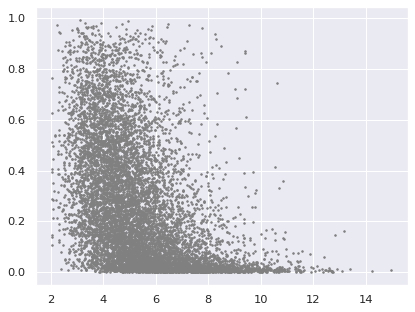

In [131]:
neighbor_100_dist = res.sorted_dist[:, 100]
plt.scatter(neighbor_100_dist, score1, s = 2, color='gray')
plt.show()

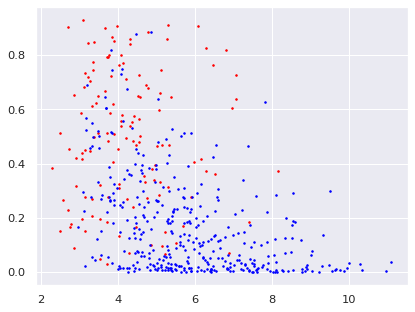

In [124]:
neighbor_100_dist = res.sorted_dist[:, 100]
plt.scatter(neighbor_100_dist[neg_sample_idx], score1[neg_sample_idx], s = 2, color='red')
plt.scatter(neighbor_100_dist[pos_sample_idx], score1[pos_sample_idx], s = 2, color='blue')
plt.show()

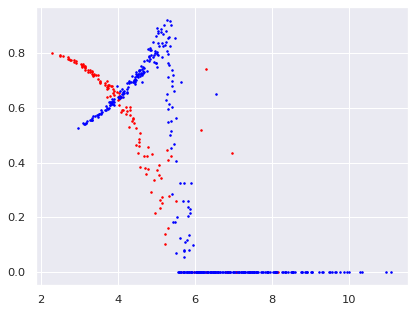

In [125]:
neighbor_100_dist = res.sorted_dist[:, 100]
plt.scatter(neighbor_100_dist[neg_sample_idx], score2[neg_sample_idx], s = 2, color='red')
plt.scatter(neighbor_100_dist[pos_sample_idx], score2[pos_sample_idx], s = 2, color='blue')
plt.show()

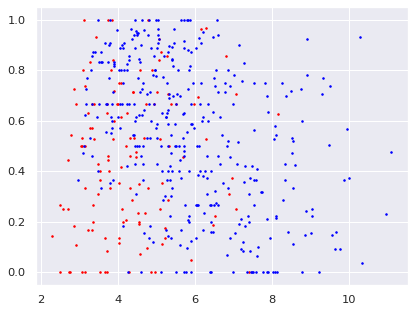

In [126]:
neighbor_100_dist = res.sorted_dist[:, 100]
plt.scatter(neighbor_100_dist[neg_sample_idx], score3[neg_sample_idx], s = 2, color='red')
plt.scatter(neighbor_100_dist[pos_sample_idx], score3[pos_sample_idx], s = 2, color='blue')
plt.show()

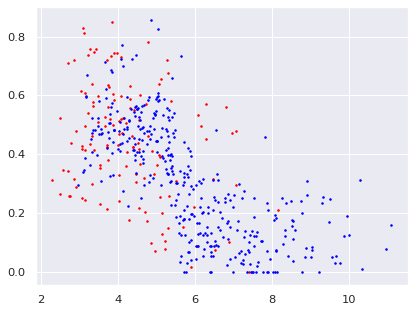

In [130]:
neighbor_100_dist = res.sorted_dist[:, 100]
plt.scatter(neighbor_100_dist[neg_sample_idx], score[neg_sample_idx], s = 2, color='red')
plt.scatter(neighbor_100_dist[pos_sample_idx], score[pos_sample_idx], s = 2, color='blue')
plt.show()

In [24]:
def rule_to_text(rule):
    conds = rule[0]
    ret = rule[1]
    return 'IF ' + ' AND '.join(['%s %s %s' % (str(a), str(b), str(c)) for (a, b, c) in conds]) + ' THEN ' + ret

In [44]:
high_conf = [i for i, p in enumerate(paths) if p['confidence'] > 0.6]

In [68]:
from lib.model_utils import export_rules_to_csv
export_rules_to_csv('csv/logistic_regression_top100.csv', model, outlier1 + outlier2)

In [42]:
import random
old_idxes = [3513, 2297, 17, 4791, 1141, 6940, 1244, 8085, 7724, 2844, 6964, 7434, 4865, 8037, 6782, 4586, 8855, 8068, 7602, 5972, 1580, 1742, 3056, 5327, 6552, 1238, 6017, 9127, 7753, 2866, 7253, 7516, 2525, 4757, 7047, 4993, 540, 846, 5670, 1650, 5506, 4208, 1223, 6596, 6306, 2784, 5545, 3477, 1623, 2293, 6800, 6744, 4001, 608, 5449, 7594, 5566, 1793, 6255, 3394, 2534, 5067, 4584, 1385, 1885, 3059, 5725, 910, 8455, 8004, 6259, 7643, 9658, 9123, 8389, 1324, 6399, 9305, 3921, 222, 4345, 7354, 2954, 5177, 4367, 5289, 916, 8127, 7951, 4006, 1872, 8087, 9404, 7062, 1479, 2801, 4449, 7885, 5365, 6609]
idxes = [i for i, p in enumerate(paths) if p['confidence'] == 0.5]
idxes = old_idxes + [i for i in idxes if i not in old_idxes]
export_rules_to_csv('csv/confidence_top300', model, idxes)

In [141]:
low_conf_idxes = idxes

In [85]:
for i in range(4):
    idx = np.flatnonzero(model.data_table['job - ' + str(i)])
    print(model.current_encoding['job'][i], np.sum(model.data_table['job - ' + str(i)]))
    for k in ['status', 'installment_rate', 'duration', 'amount', 'age', 'people_liable - 0']:
        print('%s %.4f' % (k, np.mean(model.data_table[k][idx]) - 1))

unemployed, unskilled and non-resident 22
status 1.1818
installment_rate 1.3182
duration 16.3636
amount 2744.1364
age 39.0909
people_liable - 0 -0.1364
unskilled and resident 200
status 1.4750
installment_rate 1.8450
duration 15.5350
amount 2357.4300
age 35.5850
people_liable - 0 -0.2600
skilled 630
status 1.6302
installment_rate 2.0095
duration 20.4111
amount 3069.9778
age 33.2222
people_liable - 0 -0.1254
highly skilled 148
status 1.5473
installment_rate 2.0878
duration 24.1689
amount 5434.4932
age 38.0743
people_liable - 0 -0.1419


In [26]:
new_mat = mat.copy()
for i in range(new_mat.shape[0]):
    new_mat[i] /= new_mat[i].sum()

In [27]:
res = LOCIMatrixNew(new_mat, r = 8, metric = 'euclidean', n_ticks=100)

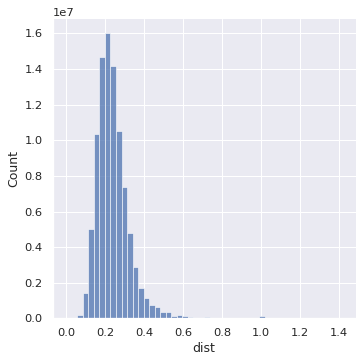

In [28]:
dist_data = pd.DataFrame({ 'dist': res.sorted_dist.reshape(-1) })
sns.displot(data=dist_data, x="dist", bins=50, log_scale=(False, False))
plt.show()

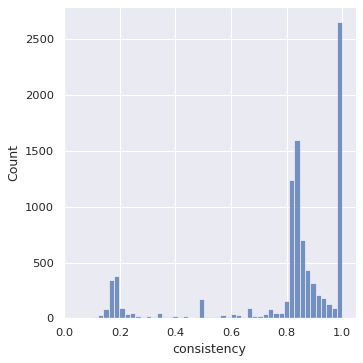

In [29]:
r = np.mean(res.sorted_dist[:, 100])
ret = res.check_consistency(r, [p['output'] for p in paths])
consistency_data = pd.DataFrame({ 'consistency': ret })
sns.displot(data=consistency_data, x="consistency", bins=50, log_scale=(False, False))
plt.show()

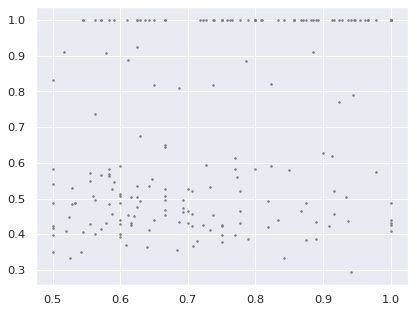

In [20]:
conf = np.array([p['confidence'] for p in paths])
idx = [i for i in range(2, 9000, 45)]
ret = np.array(ret)
plt.scatter(conf[idx], ret[idx], s = 2, color='gray')
plt.show()

In [36]:
import matplotlib as mpl

class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

for i in model.feature_pos:
    if model.feature_pos[i][0] not in feature_val_idxs:
        feature_val_idxs[model.feature_pos[i][0]] = i
        
max_ctr = lr.coef_[0].max()
min_ctr = -lr.coef_[0].min()
blues = MplColorHelper('Blues', 0, 1)
reds = MplColorHelper('Reds', 0, 1)

def display_rule(id, i):
    conds, output = model.interpret_path(model.paths[i])
    vec = lr_mat[i]
    text = '<b>IF </b> '
    for (feature, op, val) in conds:
        idx = feature_val_idxs[feature]
        ctr = np.sum(lr.coef_[0][idx] * vec[idx])
        if ctr > 0:
            ctr /= max_ctr
        else:
            ctr /= min_ctr
        cond_text = feature + ' ' + op + ' ' + str(val)
        if ctr > 0:
            rgb = blues.get_rgb(ctr * 0.9 + 0.1)
        else:
            rgb = reds.get_rgb(-ctr * 0.9 + 0.1)
        
        text_color = 'white' if np.abs(ctr) > 0.15 else 'black'
        bgcolor = 'rgb(%d,%d,%d)' % (int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
        if np.abs(ctr) < 0.03:
            bgcolor = 'white'

        text += ' <span style="background-color: %s; color:%s;">%s</span>, ' % \
            (bgcolor, text_color, cond_text)
    text = text[:-2] + ' '
    text += '<b>THEN </b> ' + output
    display(HTML('#%d, %d, LR: %.2f, Confidence: %.2f, Consistency: %.2f' % (id, i, score1[i], score3[i], score2[i])))
    display(HTML(text))


<div class="alert alert-info">
  <strong>Logistic Regression Top 100:</strong>
</div>

In [8]:
from lib.model_utils import export_rules_to_csv
export_rules_to_csv('csv/logistic_regression_top100_0714.csv', model, score1.argsort()[-100:][::-1])

In [150]:
export_rules_to_csv('csv/new_logistic_regression_top100.csv', model, outlier1 + outlier2)

In [63]:
old_outlier = [4137 ,3531 ,4448 ,5338 ,5998 ,1216 ,2361 ,5426 ,3048 ,7896 ,9155 ,9127 , 415 , 751 ,8136 ,2097 ,9367 ,9259 , 603 ,3527 ,1728 ,7021 ,6314 ,2459 ,5860 ,6526 ,3513 ,8433 ,6991 ,6872 ,2314 ,6472 ,3312 ,2539 ,3205 ,5330 , 593 ,2542 ,4443 ,5862 ,3777 ,1171 ,6596 ,3511 ,1042 ,5996 ,7355 ,9039 , 126 ,3785 , 289 ,2573 ,1202 ,5240 ,8516 ,3339 ,   1 ,4992 ,6286 ,8673 ,8068 ,4089 ,9342 ,9536 ,2226 ,8322 ,1476 ,3120 ,9510 , 942 , 166 ,9345 ,2901 ,8564 ,4158 ,5736 ,6022 ,2166 ,4410 ,6365 ,2818 ,7863 ,1427 ,4838 ,1213 ,3713 , 234 ,9488 , 661 ,2821 ,9621 ,3000 ,6720 ,2294 ,2597 ,7799 ,1837 ,6420 ,7786 ,2238]
new_outlier = outlier1 + outlier2

print(len(set(new_outlier + old_outlier)))

105


In [71]:
from lib.model_utils import export_rules_to_csv

export_rules_to_csv('csv/mixed_1_1_1_top50.csv', model, outlier)

In [33]:
for it, i in enumerate(res.sorted_dist[:, 100].argsort()[-50:][::-1]):
    print(res.sorted_dist[i, 100])
    display_rule(it, i)

0.9897605804609025


0.982607368881035


0.9820625206039383


0.9820102960016699


0.9819805060619657


0.9819805060619657


0.9819805060619657


0.9797958971132713


0.977445937049017


0.977445937049017


0.7140180778887605


0.7137231746508326


0.7024430509128573


0.7023618440065043


0.7023618440065043


0.7019556117669677


0.7011084943516834


0.6900571677434755


0.6464562295529453


0.6122882621111688


0.5891624799840314


0.5888758409453605


0.5759684827570907


0.5756081778678319


0.573721118718712


0.5736233394410591


0.5724654553712234


0.5723355765253069


0.5720241568459135


0.5707672496274985


0.5704356452719495


0.5686106898970275


0.5683619952071309


0.562351932028899


0.561976405164662


0.5580083088612006


0.5511940427910434


0.548195540568553


0.5297135854263362


0.5149084214373586


0.5


0.4989228440283098


0.4988384950168079


0.49863877194285555


0.4985130620814663


0.49844356033910087


0.49837238487842594


0.49830938435848215


0.4980860279807006


0.497824152168448


In [44]:
for it, i in enumerate(idxes[:10]):
    display_rule(it, i)

In [62]:
for it, i in enumerate(outlier1 + outlier2):
    display_rule(it, i)

In [ ]:
res = LOCIMatrixNew(mat, r = 8, metric = 'euclidean', n_ticks=100)

<div class="alert alert-info">
  <strong>Consistency Top 50 (20 neighbors):</strong>
</div>

In [185]:
r = np.mean(res.sorted_dist[:, 20])
ret20 = res.check_consistency(r, [p['output'] for p in paths])
idx20 = np.array(ret20).argsort()[:50]
for it, i in enumerate(idx20):
    display_rule(it, i) 

<div class="alert alert-info">
  <strong>Consistency Top 50 (50 neighbors):</strong>
</div>

In [186]:
r50 = np.mean(res.sorted_dist[:, 50])
ret50 = res.check_consistency(r, [p['output'] for p in paths])
idx50 = np.array(ret50).argsort()[:50]
for it, i in enumerate(idx50):
    display_rule(it, i) 

<div class="alert alert-info">
  <strong>Consistency Top 50 (100 neighbors):</strong>
</div>

In [40]:
export_rules_to_csv('0714_consistency_top200', model, idx100)

In [41]:
r100 = np.mean(res.sorted_dist[:, 100])
ret100 = res.check_consistency(r100, [p['output'] for p in paths])
idx100 = np.array(ret100).argsort()[:10]
for it, i in enumerate(idx100):
    display_rule(it, i) 

<div class="alert alert-info">
  <strong>Low confidence Top 50:</strong>
</div>

In [188]:
for it, i in enumerate(low_conf_idxes):
    display_rule(it, i) 